# Impact on the blood supply

Using script 6_changingtime.py, predictions were made for each observation at different timepoints, weekly between one year before and one year after the original donation date. This simulates usage of the prediction model by blood banks, when donors would be invited as soon as the model predicts 'no deferral'. This notebook shows invitation dates as suggested by the prediction model (still taking into account the minimum donation interval, which is 91 days for women and 61 days for men), and how the number of blood bank visits would change.

### Importing packages

In [1]:
import numpy as np
import pandas as pd 
import datetime
import pickle
import matplotlib.pyplot as plt
import matplotlib as mpl
import bisect
from sklearn.preprocessing import StandardScaler

pd.set_option('display.max_columns', None)

### Functions to read files created by 6_changingtime.py and to plot results

In [2]:
def get_closest_pred(x):
    intvals = list(range(-364, 371, 7))
    i = bisect.bisect_right(intvals, x)
    return(intvals[i])

def get_first_pos_pred(x, fulldf):
    firstcol = list(fulldf.columns).index('Hbdef_pred_' + str(int(x['first_possible_invite'])))
    all_pred_0 = x[firstcol:-2][x[firstcol:-2] == 0]
    if len(all_pred_0) == 0:
        return(np.nan)
    else:
        return(x[firstcol:-2][x[firstcol:-2] == 0].index[0][11:])

def gather_results(sex, nbacks, foldersuffix=''):
    df = list()
    for nback in nbacks:
        scaler = pickle.load(open('../results/scalers'+foldersuffix+'/'+sex+'_'+str(nback)+'.pkl', 'rb'))
        dfsub = pd.read_pickle('../../data/pred_timechange'+foldersuffix+'/data_res_'+sex+'_'+str(nback)+'.pkl')
        dfsub[dfsub.columns[:-107]] = scaler.inverse_transform(dfsub[dfsub.columns[:-107]])
        df.append(dfsub)
    df = pd.concat(df)
    df = df[~df.index.duplicated(keep='first')]
    interval = 61 if sex == 'men' else 91
    df['first_possible_donation'] = df['DaystoPrev1'] * -1 + interval
    df['first_possible_invite'] = df['first_possible_donation'].apply(get_closest_pred)
    df['first_pos_pred'] = pd.to_numeric(df.apply(get_first_pos_pred, fulldf=df, axis=1))
    return(df)
    
def plot_newinvites(df_f, df_m, save=False):
    fig, ax = plt.subplots(2, 2, figsize=(12,12))

    df_f_nonan = df_f.dropna(subset=['first_pos_pred'])
    df_m_nonan = df_m.dropna(subset=['first_pos_pred'])

    ax[0,0].hist(df_f_nonan.loc[df_f_nonan['Hb_deferral'] == 0, 'first_pos_pred'], bins=range(-364, 371, 30), cumulative=True, 
                 facecolor='xkcd:purple', edgecolor='k',fill=True)
    ax[0,1].hist(df_f_nonan.loc[df_f_nonan['Hb_deferral'] == 1, 'first_pos_pred'], bins=range(-364, 371, 30), cumulative=True, 
                 facecolor='xkcd:light blue', hatch='/', edgecolor='k',fill=True)
    ax[1,0].hist(df_m_nonan.loc[df_m_nonan['Hb_deferral'] == 0, 'first_pos_pred'], bins=range(-364, 371, 30), cumulative=True, 
                 facecolor='xkcd:purple', edgecolor='k',fill=True)
    ax[1,1].hist(df_m_nonan.loc[df_m_nonan['Hb_deferral'] == 1, 'first_pos_pred'], bins=range(-364, 371, 30), cumulative=True, 
                 facecolor='xkcd:light blue', hatch='/', edgecolor='k',fill=True)

    ax[0,0].set_title('Female donors, not deferred at t=0')
    ax[0,1].set_title('Female donors, deferred at t=0')
    ax[1,0].set_title('Male donors, not deferred at t=0')
    ax[1,1].set_title('Male donors, deferred at t=0')

    ax[0,0].axvline(0, color='black')
    ax[0,1].axvline(0, color='black')
    ax[1,0].axvline(0, color='black')
    ax[1,1].axvline(0, color='black')

    for aks in ax.flatten():
        aks.set_xlabel('Change in donation date in days \n(t=0 is original donation day)')
        aks.set_ylabel('Number of donors invited (cumulative)')

    plt.show()
    if save:
        plt.savefig('../results/plots_performance/' + save + '.png')
        
def get_invitecats(df_f, df_m, save=False):
    df_f['sex'] = 'F'
    df_m['sex'] = 'M'
    df_intervals = pd.concat([df_f, df_m]).loc[:, ['sex', 'DaystoPrev1', 'first_pos_pred', 'Hb_deferral', 'Hbdef_pred']]
    df_intervals['DaystoPrevNew'] = df_intervals['DaystoPrev1'] + df_intervals['first_pos_pred']
    
    df_intervals['invite_category'] = pd.cut(df_intervals['first_pos_pred'], bins=[-400, -14, 14, 90, 400])
    df_intervals['invite_category'] = df_intervals['invite_category'].astype(str)
    
    if save:
        df_intervals.to_pickle('../results/newinvites/' + save + '.pkl')
    
    return(df_intervals)

def print_impact(df_intervals):
    summ_int = df_intervals.groupby(['Hb_deferral', 'invite_category']).count().drop(columns=['DaystoPrev1','first_pos_pred','Hbdef_pred','DaystoPrevNew']).rename(columns={'sex':'count'})

    tot_0 = int(np.sum(summ_int.loc[0, ]))
    print('Not deferred on original donation date')
    print('  ', summ_int.loc[(0, '(-400, -14]'), 'count'], '=', int(round(summ_int.loc[(0, '(-400, -14]'), 'count']/tot_0*100, 0)), '% donors more than two weeks earlier')
    print('  ', summ_int.loc[(0, '(-14, 14]'), 'count'], '=', int(round(summ_int.loc[(0, '(-14, 14]'), 'count']/tot_0*100, 0)), '% donors within two weeks')
    print('  ', summ_int.loc[(0, '(14, 90]'), 'count'], '=', int(round(summ_int.loc[(0, '(14, 90]'), 'count']/tot_0*100, 0)), '% donors two weeks - three months later')
    print('  ', summ_int.loc[(0, '(90, 400]'), 'count'], '=', int(round(summ_int.loc[(0, '(90, 400]'), 'count']/tot_0*100, 0)), '% donors more than three months later')
    print('  ', summ_int.loc[(0, 'nan'), 'count'], '=', int(round(summ_int.loc[(0, 'nan'), 'count']/tot_0*100, 0)), '% donors not invited within year')

    tot_1 = int(np.sum(summ_int.loc[1, ]))
    print('Deferred on original donation date')
    print('  ', summ_int.loc[(1, '(-400, -14]'), 'count'], '=', int(round(summ_int.loc[(1, '(-400, -14]'), 'count']/tot_1*100, 0)), '% donors more than two weeks earlier')
    print('  ', summ_int.loc[(1, '(-14, 14]'), 'count'], '=', int(round(summ_int.loc[(1, '(-14, 14]'), 'count']/tot_1*100, 0)), '% donors within two weeks')
    print('  ', summ_int.loc[(1, '(14, 90]'), 'count'], '=', int(round(summ_int.loc[(1, '(14, 90]'), 'count']/tot_1*100, 0)), '% donors two weeks - three months later')
    print('  ', summ_int.loc[(1, '(90, 400]'), 'count'], '=', int(round(summ_int.loc[(1, '(90, 400]'), 'count']/tot_1*100, 0)), '% donors more than three months later')
    print('  ', summ_int.loc[(1, 'nan'), 'count'], '=', int(round(summ_int.loc[(1, 'nan'), 'count']/tot_1*100, 0)), '% donors not invited within year')
    
    df_ints = df_intervals.dropna()

    median_old_m = np.median(df_ints.loc[df_ints.sex == 'M', 'DaystoPrev1'])
    median_old_f = np.median(df_ints.loc[df_ints.sex == 'F', 'DaystoPrev1'])

    median_new_m = np.median(df_ints.loc[df_ints.sex == 'M', 'DaystoPrevNew'])
    median_new_f = np.median(df_ints.loc[df_ints.sex == 'F', 'DaystoPrevNew'])

    print('Median donation interval for men goes from {} to {} days.'.format(median_old_m, median_new_m))
    print('Median donation interval for women goes from {} to {} days.'.format(median_old_f, median_new_f))

    visits_relative = (sum(df_ints['DaystoPrev1'])) / (sum(df_ints['DaystoPrevNew']))
    print('Number of blood bank visits increases by {}%.'.format(round((visits_relative-1)*100)))

# Plot of cumulative number of invited donors
Split for women and men, and for deferred and non-deferred donors (at the original donation date).

In [3]:
# Range goes backward rather than forward so the files with most predictor vars are loaded first
# This makes indexing easier
df_f = gather_results('women', range(5,1,-1))
df_m = gather_results('men', range(5,1,-1))

# Save version of the data with only timing variables
df_f = df_f.drop(columns=list(df_f.columns[:14]) + list(df_f.columns[15:23])).reset_index()
df_f.to_pickle('../results/newinvites/predictions_women.pkl')

df_m = df_m.drop(columns=list(df_m.columns[:14]) + list(df_m.columns[15:23])).reset_index()
df_m.to_pickle('../results/newinvites/predictions_men.pkl')

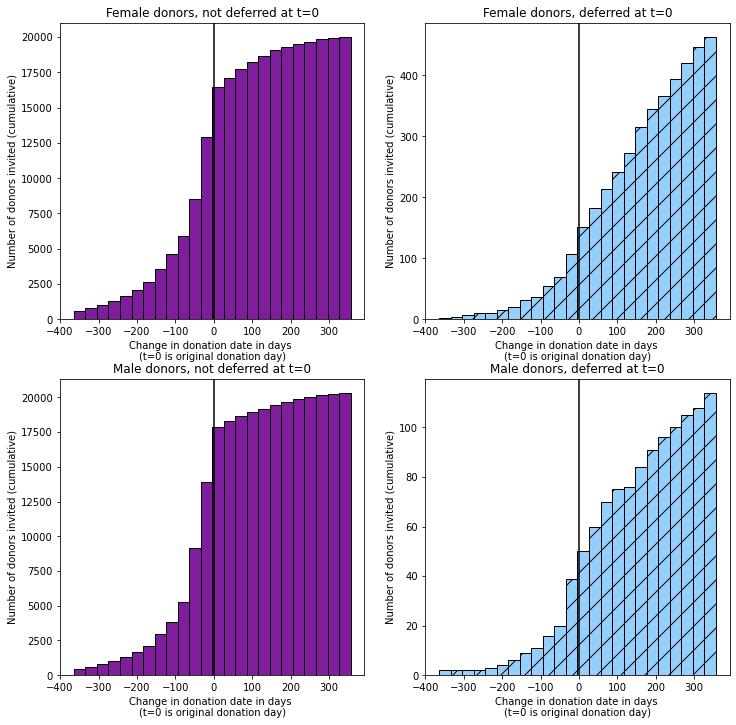

<Figure size 432x288 with 0 Axes>

In [4]:
df_f = pd.read_pickle('../results/newinvites/predictions_women.pkl')
df_m = pd.read_pickle('../results/newinvites/predictions_men.pkl')
plot_newinvites(df_f, df_m, save='invites_datechange')

In [5]:
df_intervals = get_invitecats(df_f, df_m, save='invite_intervals')
print_impact(df_intervals)

Not deferred on original donation date
   23905 = 57 % donors more than two weeks earlier
   10056 = 24 % donors within two weeks
   2419 = 6 % donors two weeks - three months later
   4005 = 10 % donors more than three months later
   1247 = 3 % donors not invited within year
Deferred on original donation date
   132 = 18 % donors more than two weeks earlier
   57 = 8 % donors within two weeks
   95 = 13 % donors two weeks - three months later
   305 = 41 % donors more than three months later
   152 = 21 % donors not invited within year
Median donation interval for men goes from 98.0 to 64.0 days.
Median donation interval for women goes from 133.0 to 98.0 days.
Number of blood bank visits increases by 29%.


# New invite dates by SVM using only Hb variables

In [6]:
df_f_onlyhb = gather_results('women', range(5,1,-1), foldersuffix='_onlyhb')
df_m_onlyhb = gather_results('men', range(5,1,-1), foldersuffix='_onlyhb')

# Save version of the data with only timing variables
df_f_onlyhb = df_f_onlyhb.drop(columns=list(df_f_onlyhb.columns[:3]) + list(df_f_onlyhb.columns[4:12])).reset_index()
df_f_onlyhb.to_pickle('../results/newinvites/predictions_women_onlyhb.pkl')

df_m_onlyhb = df_m_onlyhb.drop(columns=list(df_m_onlyhb.columns[:3]) + list(df_m_onlyhb.columns[4:12])).reset_index()
df_m_onlyhb.to_pickle('../results/newinvites/predictions_men_onlyhb.pkl')

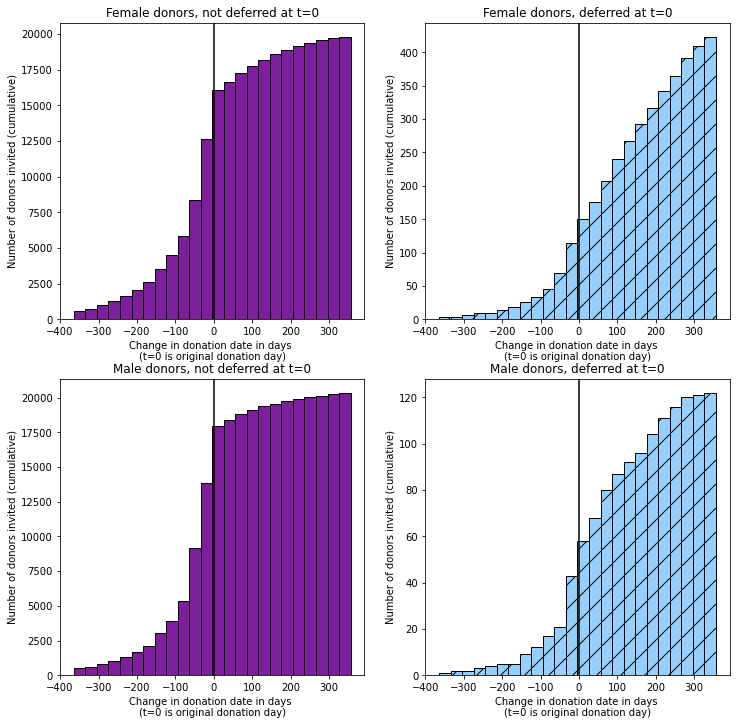

<Figure size 432x288 with 0 Axes>

In [7]:
df_f_onlyhb = pd.read_pickle('../results/newinvites/predictions_women_onlyhb.pkl')
df_m_onlyhb = pd.read_pickle('../results/newinvites/predictions_men_onlyhb.pkl')
plot_newinvites(df_f_onlyhb, df_m_onlyhb, save='invites_datechange_onlyhb')

In [8]:
df_intervals_onlyhb = get_invitecats(df_f_onlyhb, df_m_onlyhb, save='invite_intervals_onlyhb')
print_impact(df_intervals_onlyhb)

Not deferred on original donation date
   23641 = 57 % donors more than two weeks earlier
   9885 = 24 % donors within two weeks
   2611 = 6 % donors two weeks - three months later
   4034 = 10 % donors more than three months later
   1461 = 4 % donors not invited within year
Deferred on original donation date
   140 = 19 % donors more than two weeks earlier
   56 = 8 % donors within two weeks
   92 = 12 % donors two weeks - three months later
   260 = 35 % donors more than three months later
   193 = 26 % donors not invited within year
Median donation interval for men goes from 98.0 to 64.0 days.
Median donation interval for women goes from 133.0 to 98.0 days.
Number of blood bank visits increases by 27%.
